# Evaluation of Bangla ASR on RawNet

### Procedure:
1. The Dataset comes with flac files. Hence we first convert the dataset in wav format.
2. We load Bangla ASR dataset
3. We load the RawNet Model with the best weights provided in the RawNet repository.
4. We extract the Embeddings of Bangla ASR dataset using RawNet.
5. We evaluate the embeddings.

## Necessary Imports

In [1]:
import os
import glob

import sys
import csv

from pathlib import PurePath, Path
from pydub import AudioSegment

from tqdm import tqdm

## Constants and directories

In [2]:
# Directories should have a trailing '/' to avoid path related errors

CURRENT_WORKING_DIRECTORY = "W:/SpeakerRecognitionResearch/"
BANGLA_ASR_FLAC_LOCATION = "data/BanglaASR/FlacFiles/"
BANGLA_ASR_WAV_LOCATION = "data/BanglaASR/WavFiles/"

RAWNET2_BEST_WEIGHTS_LOCATION = "data/RawNet2/rawnet2_best_weights.pt"

# This file is provided with BANGLA_ASR dataset
# It contains the anonymous speaker id of each audio
BANGLA_ASR_TSV_LOCATION = "data/BanglaASR/utt_spk_text.tsv"

# To avoid file location related errors, we make sure "SpeakerRecognitionResearch" root folder is the current working directory.
os.chdir(CURRENT_WORKING_DIRECTORY)
os.getcwd()

'W:\\SpeakerRecognitionResearch'

# 1. Converting FLAC to WAV

In [3]:
# We calculate the rows provided in utt_spk_text.tsv, this number can be used to verify if we have all the files from the dataset.

def get_number_of_utt_in_tsv(tsv_loc):
    total_utterrances = 0

    with open(tsv_loc, encoding="utf-8") as tsvfile:
        tsvreader = csv.reader(tsvfile, delimiter="\t", quoting=csv.QUOTE_NONE)
        for line in tsvreader:
            total_utterrances += 1
    
    return total_utterrances


In [4]:
def get_relative_location_of_audio_files(root_path, audio_format="wav"):
    # Traverses recursively through the root folder
    # Returns list of relative locations to all the files 
    # matching the audio format provided

    pattern = '**/*.' + audio_format
    files = glob.glob(root_path + pattern , recursive=True)

    # Normalize the file paths. To get file paths with '/' or '\\' consistently depending on OS
    files = [os.path.normpath(i) for i in files]
    return files

In [5]:
file_locs = get_relative_location_of_audio_files(BANGLA_ASR_FLAC_LOCATION, audio_format="flac")

number_of_files = len(file_locs)
number_of_rows_in_tsv = get_number_of_utt_in_tsv(BANGLA_ASR_TSV_LOCATION)

assert number_of_files == number_of_rows_in_tsv , "Number of files in the dataset doesn't match the number of rows provided in the tsv file. Please check the dataset."

In [6]:
# Paths may be in a non normalized form,
# So, trying to replace portions of them may lead to unwanted errors

def replace_root_of_path(path, old_root, new_root):
    path = str(os.path.normpath(path))
    old_root = str(os.path.normpath(old_root))
    new_root = str(os.path.normpath(new_root))

    return path.replace(old_root, new_root)

In [7]:
assert replace_root_of_path(path="foo/bar/hello/00/a.jpg", old_root="foo/bar", new_root="spam") == os.path.normpath("spam/hello/00/a.jpg"), "The root replacing is not working."

In [8]:
# Python does not automatically create directory structure when creating a file
# This function will create the subdirectories required

def mkdirs_from_filepath(file_path):

    parent = Path(file_path).parent
    os.makedirs(parent, exist_ok=True)

# mkdirs_from_filepath("hello/bar/foo/k.jpg")

In [9]:
def convert_flacs_to_wavs(flacs_path, wavs_path):
    flac_files = get_relative_location_of_audio_files(flacs_path, audio_format="flac")

    # wav file locations will be the same as the flac files
    # Only the root folder will be changed
    wav_files = [replace_root_of_path(flac_file_path, flacs_path, wavs_path) for flac_file_path in flac_files]

    for flac_file, wav_file in tqdm(zip(flac_files, wav_files), total=len(wav_files)):

        flac_file = PurePath(flac_file)

        # Replace .flac with .wav from name
        wav_file = wav_file.replace(wav_file.split(".")[-1], "wav")

        mkdirs_from_filepath(wav_file)

        flac_tmp_audio_data = AudioSegment.from_file(flac_file, flac_file.suffix[1:])
        flac_tmp_audio_data.export(wav_file, format="wav")


In [10]:
# Leave this function call commented out to avoid unwanted conversions

print("Do you want to convert the .flac files in {} to .wav files in the directory {} ?".format(BANGLA_ASR_FLAC_LOCATION, BANGLA_ASR_WAV_LOCATION))
user_input = input("Type YES_AND_YES to continue:")

if user_input == "YES_AND_YES":
    convert_flacs_to_wavs(BANGLA_ASR_FLAC_LOCATION, BANGLA_ASR_WAV_LOCATION)
else:
    print("Conversion aborted!")

Do you want to convert the .flac files in data/BanglaASR/FlacFiles/ to .wav files in the directory data/BanglaASR/WavFiles/ ?
Conversion aborted!


# 2. Loading BanglaAsrDataset

In this step we load the RawNet provided [here](https://github.com/Jungjee/RawNet/blob/master/python/RawNet2/Pre-trained_model/model_RawNet2_original_code.py). We changed the file name to simply model_RawNet2.py in our use. The model is then initialized with the best weights file that can be found [here](https://github.com/Jungjee/RawNet/blob/master/python/RawNet2/Pre-trained_model/rawnet2_best_weights.pt).

In [11]:
import soundfile as sf
import numpy as np

from torch.utils import data

In [12]:
# Using default parameter values used in the VoxCeleb Dataset

WINDOW_SIZE = 11810
NB_SAMP = 59049

### Bangla ASR Dataset for PyTorch usage

In [13]:
class BanglaAsrDataset(data.Dataset):
	def __init__(self, list_IDs, nb_samp = 0, window_size = 0, labels = {}, cut = True, norm_scale = True):
		'''
		self.list_IDs	: list of strings (each string: utt key)
		self.labels		: dictionary (key: utt key, value: label integer)
		self.nb_samp	: integer, the number of timesteps for each mini-batch
		cut				: (boolean) adjust utterance duration for mini-batch construction
		return_label	: (boolean) 
		norm_scale		: (boolean) normalize scale alike SincNet github repo
		'''
		self.list_IDs = list_IDs
		self.window_size = window_size
		self.nb_samp = nb_samp
		self.labels = labels
		self.cut = cut
		self.norm_scale = norm_scale
		if self.cut and self.nb_samp == 0: 
			raise ValueError('when adjusting utterance length, "nb_samp" should be passed as parameter')

	def _normalize_scale(self, x):
		'''
		Normalize sample scale alike SincNet.
		'''
		return x/np.max(np.abs(x))

	def __len__(self):
		return len(self.list_IDs)

	def __getitem__(self, index):
		ID = self.list_IDs[index]
		try:
			X, _ = sf.read(ID) 
			X = X.astype(np.float64)
		except:
			raise ValueError('%s'%ID)

		if self.norm_scale:
			X = self._normalize_scale(X).astype(np.float32)
		X = X.reshape(1,-1)

		list_X = []
		nb_time = X.shape[1]
		if nb_time < self.nb_samp:
			nb_dup = int(self.nb_samp / nb_time) + 1
			list_X.append(np.tile(X, (1, nb_dup))[:, :self.nb_samp][0])
		elif nb_time > self.nb_samp:
			step = self.nb_samp - self.window_size
			iteration = int( (nb_time - self.window_size) / step ) + 1
			for i in range(iteration):
				if i == 0:
					list_X.append(X[:, :self.nb_samp][0])
				elif i < iteration - 1:
					list_X.append(X[:, i*step : i*step + self.nb_samp][0])
				else:
					list_X.append(X[:, -self.nb_samp:][0])
		else :
			list_X.append(X[0])

		
		filename_from_path = Path(ID).stem
		y = self.labels[filename_from_path]

		return list_X, y, ID

In [14]:
def generate_labels_from_tsv(wav_list, tsv_loc):
    labels = {}

    with open(tsv_loc, encoding="utf-8") as tsvfile:
        tsvreader = csv.reader(tsvfile, delimiter="\t", quoting=csv.QUOTE_NONE)
        for line in tsvreader:
            wav_file_name = line[0]
            speaker_id = line[1]

            labels[wav_file_name] = speaker_id

    return labels

In [15]:
wav_list = get_relative_location_of_audio_files(BANGLA_ASR_WAV_LOCATION)

labels = generate_labels_from_tsv(wav_list, BANGLA_ASR_TSV_LOCATION)

assert labels['000020a912'] == '16cfb', "Either file id to speaker id mapping changed, or labels were not retrieved properly."

In [16]:
bangla_asr_dataset = BanglaAsrDataset(
    list_IDs=wav_list,
    labels=labels,
    window_size=WINDOW_SIZE,
    nb_samp=NB_SAMP,
)

In [17]:
bangla_asr_dataset[0]

([array([ 0.01430657,  0.01109489,  0.01080292, ..., -0.00583942,
         -0.00554745, -0.00963504], dtype=float32)],
 '16cfb',
 'data\\BanglaASR\\WavFiles\\asr_bengali_0\\asr_bengali\\data\\00\\000020a912.wav')

# 3. Loading RawNet with Best Weights

In [18]:
import torch
from model_RawNet2 import RawNet

import pickle

In [19]:
# Default value was 8, however NoteBook doesn't support >0
NB_WORKER = 0

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {}.".format(device))
if device=="cuda": print(torch.cuda.get_device_name(0))

Using cuda.
NVIDIA GeForce GTX 1050


In [21]:
model_dict = {}
model_dict['nb_classes'] = 6112
model_dict['first_conv'] = 251
model_dict['in_channels'] = 1
model_dict['filts'] = [128, [128,128], [128,256], [256,256]]
model_dict['m_blocks'] = [2, 4]
model_dict['nb_fc_att_node'] =[1]
model_dict['nb_fc_node'] = 1024
model_dict['gru_node'] = 1024
model_dict['nb_gru_layer'] = 1
model_dict['nb_samp'] = 59049

In [22]:
model = RawNet(model_dict, device)
model.load_state_dict(torch.load(RAWNET2_BEST_WEIGHTS_LOCATION))
model.to(device)

RawNet(
  (ln): LayerNorm()
  (first_conv): SincConv_fast()
  (first_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lrelu): LeakyReLU(negative_slope=0.01)
  (lrelu_keras): LeakyReLU(negative_slope=0.3)
  (block0): Sequential(
    (0): Residual_block(
      (lrelu): LeakyReLU(negative_slope=0.01)
      (lrelu_keras): LeakyReLU(negative_slope=0.3)
      (conv1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (mp): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (block1): Sequential(
    (0): Residual_block(
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (lrelu): LeakyReLU(negative_slope=0.01)
      (lrelu_keras): LeakyReLU(negative_slope=0.3)
      (conv1): Conv1d(128

In [23]:
# Create DataLoader for Dataset

bangla_asr_dataloader = data.DataLoader(bangla_asr_dataset,
            batch_size = 1, 
            shuffle = False,
            drop_last = False,
            num_workers = NB_WORKER)

# 4. Extract Embeddings

In [24]:
EMBEDDINGS_SAVE_FILE_LOCATION = "notebooks/EvaluateAsrDatasetOnRawNet/out/embeddings.pkl"

In [25]:
# Model must be in eval mode to extract embedding

model.eval()

RawNet(
  (ln): LayerNorm()
  (first_conv): SincConv_fast()
  (first_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lrelu): LeakyReLU(negative_slope=0.01)
  (lrelu_keras): LeakyReLU(negative_slope=0.3)
  (block0): Sequential(
    (0): Residual_block(
      (lrelu): LeakyReLU(negative_slope=0.01)
      (lrelu_keras): LeakyReLU(negative_slope=0.3)
      (conv1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (mp): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (block1): Sequential(
    (0): Residual_block(
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (lrelu): LeakyReLU(negative_slope=0.01)
      (lrelu_keras): LeakyReLU(negative_slope=0.3)
      (conv1): Conv1d(128

In [26]:
user_choice = input("Do You Want To Generate Embeddings? Type YES/NO")

if user_choice == "YES":
    #Generating Embeddings
    with torch.set_grad_enabled(False):
        #1st, extract speaker embeddings.

        # Each m_batch is a single wav
        with open(EMBEDDINGS_SAVE_FILE_LOCATION, 'ab+') as fp:
            for m_batch in tqdm(bangla_asr_dataloader, total=len(wav_list)):
                l_code = []
                for batch in m_batch[0]:
                    batch = batch.to(device)
                    code = model(x = batch, is_test=True)
                    l_code.extend(code.cpu().numpy())
                file_location = m_batch[2][0]
                l_embedding = np.mean(l_code, axis=0)
                pickle.dump((file_location, l_embedding), fp)

In [146]:
# Load from pickle
# embeddings[path] = numpy_array

embeddings = {}
with open(EMBEDDINGS_SAVE_FILE_LOCATION, 'rb') as fr:
    try:
        while True:
            data = pickle.load(fr)
            embeddings[data[0]] = data[1]
    except EOFError:
        pass
len(embeddings.keys())

218703

In [149]:
embeddings[list(embeddings.keys())[0]]

array([-0.00931683, -0.05722116,  0.09655098, ..., -0.07048331,
        0.11888041,  0.00730451], dtype=float32)

In [150]:
def speech_per_speaker(labels):
    # Returns a dictionary containing the number of utterrances for each speaker
    speaker_ids = {}
    for wav in labels.keys():
        spk_id = labels[wav]
        if spk_id in speaker_ids.keys():
            speaker_ids[spk_id] += 1
        else:
            speaker_ids[spk_id] = 0

    return speaker_ids

In [151]:
speech_per_spk = speech_per_speaker(labels)
total_number_of_speakers = len(speech_per_spk.keys())

# This is the total number of speakers in this dataset
total_number_of_speakers

508

# 5. Evaluate Bangla ASR on RawNet

In [175]:
from sklearn.metrics import roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d

In [203]:
# Specifies how many trials to make
# In other words, how many times to calculate cos_sim to calculate EER
NB_TRIALS = 200000

# Where the validation trials should be saved
VAL_TRIAL_LOCATION = "notebooks/EvaluateAsrDatasetOnRawNet/out/val_trials.txt"

In [204]:
def cos_sim(a,b):
    return np.dot(a,b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [205]:
first_key = list(embeddings.keys())[0]
second_key = list(embeddings.keys())[1]

cos_sim(embeddings[first_key], embeddings[second_key])

0.1616441

In [206]:
def get_speaker_to_paths_dict(wav_list, labels):
    
    spk_to_path_d = {}

    for wav_path in wav_list:
        wav_name = Path(wav_path).stem
        spk_id = labels[wav_name]

        if spk_id in spk_to_path_d.keys():
            spk_to_path_d[spk_id].append(wav_path)
        else:
            spk_to_path_d[spk_id] = [wav_path]
    
    return spk_to_path_d

In [207]:
spk_to_paths_d = get_speaker_to_paths_dict(wav_list, labels)

assert len( list(filter(lambda wav_path: "003399c103" in wav_path, spk_to_paths_d["948d3"])) )==1, "Verify if the tsv file is upto date with the Dataset"

In [208]:
# This function will generate a file that will contain which two files should be compared with cos similarities
# Format:
# 1 spk/_1_/audio/1.wav spk/_1_/audio/2.wav
# 0 spk/_1_/audio/1.wav spk/_2_/audio/1.wav

def generate_validation_trials(wav_list, nb_trial, val_trial_location, speaker_to_paths_d):
    val_trial_file = open(val_trial_location, 'w')

    # We define, same speaker trial as target trial
    # Target trial: 1; Non-trg: 0

    # There will be equal numbers of target and non target trials
    nb_target_trials = int(nb_trial / 2)
        
    speakers_list = list(speaker_to_paths_d.keys())

    #compose target trials
    selected_spks = np.random.choice(speakers_list, size=nb_target_trials, replace=True)
    for spk in selected_spks:
        wav_paths_of_speaker = speaker_to_paths_d[spk]
        utt_a, utt_b = np.random.choice(wav_paths_of_speaker, size=2, replace=False)
        val_trial_file.write('1 %s %s\n'%(utt_a, utt_b))

    #compose non-target trials
    for i in range(nb_target_trials):
        two_different_speakers = np.random.choice(speakers_list, size=2, replace = False)
        utt_a = np.random.choice(speaker_to_paths_d[two_different_speakers[0]], size=1)[0]
        utt_b = np.random.choice(speaker_to_paths_d[two_different_speakers[1]], size=1)[0]
        val_trial_file.write('0 %s %s\n'%(utt_a, utt_b))

    val_trial_file.close()

In [209]:
generate_validation_trials(wav_list=wav_list, 
                            nb_trial=NB_TRIALS, 
                            val_trial_location=VAL_TRIAL_LOCATION, 
                            speaker_to_paths_d=spk_to_paths_d)

In [210]:
# Retrieve validation trials from valtrial file
def get_validation_trials(val_trial_location):
    valtrials = []
    with open(val_trial_location, "r") as file:
        for line in file.readlines():
            line = line.rstrip("\n")
            splitted_line = line.split(" ")

            valtrials.append( (int(splitted_line[0]), splitted_line[1], splitted_line[2]) )

    return valtrials

In [211]:
validation_trials = get_validation_trials(VAL_TRIAL_LOCATION)

In [216]:
def get_y_true_and_score(validation_trials):
    y_true = [vt[0] for vt in validation_trials]
    y_score = []

    for vt in validation_trials:
        utt_1 = embeddings[vt[1]]
        utt_2 = embeddings[vt[2]]
        
        score = cos_sim(utt_1, utt_2)
        y_score.append(score)

    return y_true, y_score

In [217]:
y_true, y_score = get_y_true_and_score(validation_trials)

### EER Score

In [219]:
def calculate_eer(y_true, y_score):
    fpr, tpr, _  = roc_curve(y_true=y_true, y_score=y_score, pos_label=1)
    eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    return eer

In [221]:
eer = calculate_eer(y_true, y_score)
eer

0.09767500000000003

In [236]:
# Graph NB_SAMPLE / eer graph

eers = []
nb_trials = [i for i in range(2500, 200001, 2500)]

for nb_trial in nb_trials:
    print("Number of trials:", nb_trial, end=" ")
    generate_validation_trials(wav_list=wav_list, 
                            nb_trial=nb_trial, 
                            val_trial_location=VAL_TRIAL_LOCATION, 
                            speaker_to_paths_d=spk_to_paths_d)

    validation_trials = get_validation_trials(VAL_TRIAL_LOCATION)

    y_true, y_score = get_y_true_and_score(validation_trials)

    eer = calculate_eer(y_true, y_score)
    eers.append(eer)
    print("EER:", eer)
    

Number of trials: 2500 EER: 0.0871999999996136
Number of trials: 5000 EER: 0.09659999999999998
Number of trials: 7500 EER: 0.10579999999999981
Number of trials: 10000 EER: 0.0982333333333088
Number of trials: 12500 EER: 0.09823999999991792
Number of trials: 15000 EER: 0.09923333333333335
Number of trials: 17500 EER: 0.09759999999999987
Number of trials: 20000 EER: 0.09760000000094722
Number of trials: 22500 EER: 0.09795555555557549
Number of trials: 25000 EER: 0.09663999999999622
Number of trials: 27500 EER: 0.09679999999998892
Number of trials: 30000 EER: 0.09446666666484635
Number of trials: 32500 EER: 0.09655384615532071
Number of trials: 35000 EER: 0.09714285714286672
Number of trials: 37500 EER: 0.09866666666666694
Number of trials: 40000 EER: 0.0967625
Number of trials: 42500 EER: 0.09524705882329353
Number of trials: 45000 EER: 0.09605925925925901
Number of trials: 47500 EER: 0.09730526315833357
Number of trials: 50000 EER: 0.10039999999872673
Number of trials: 52500 EER: 0.0969

In [248]:
import matplotlib.pyplot as plt
from pylab import text
%matplotlib inline

Average EER: 0.09722838643830292


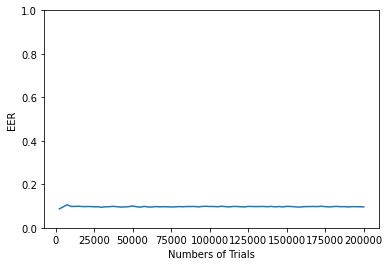

In [257]:
plt.plot(nb_trials, eers)
axes = plt.gca()
axes.set_xlabel("Numbers of Trials")
axes.set_ylabel("EER")
axes.set_ylim(0,1.0)

print("Average EER:", sum(eers)/len(eers))
